# Network continuity with OS Open Roads data

## Data Source

The following example uses the [OS Open Roads](https://osdatahub.os.uk/downloads/open/OpenRoads) dataset, which is available under the [Open Government License](http://os.uk/opendata/licence).

## Preparation

The following example assumes:
- That the notebook is being run from a cloned `cityseer-api` repository.
- That the above dataset has been downloaded to `temp/os_open_roads/oproad_gb.gpkg` as a relative path. If running this notebook directly from within a clone of the `cityseer-api` repo, then this equates to the `cityseer-api/temp/os_open_roads/oproad_gb.gpkg` path. Please edit the paths and path setup in this cell if you are using different directories.


In [1]:
from __future__ import annotations

from pathlib import Path

repo_path = Path.cwd()
if str(repo_path).endswith("connectivity"):
    repo_path = Path.cwd() / "../.."
if not str(repo_path.resolve()).endswith("cityseer-api"):
    raise ValueError("Please check your notebook working directory relative to your project and data paths.")

open_roads_path = Path(repo_path / "temp/os_open_roads/oproad_gb.gpkg")
print("data path:", open_roads_path)
print("path exists:", open_roads_path.exists())

data path: /Users/gareth/dev/benchmark-urbanism/cityseer-api/demos/connectivity/../../temp/os_open_roads/oproad_gb.gpkg
path exists: True


### Extents

Instead of loading the entire dataset, we'll use a bounding box to only load an area of interest.

In [2]:
from pyproj import Transformer
from shapely import geometry

from cityseer.tools import io

# create graph
lng, lat = -1.7063649924889566, 52.19277374082795  # stratford-upon-avon
# lng, lat = -0.13039709427587876, 51.516434828344366  # london
# lng, lat = 18.425702641104582, -33.9204746754594  # cape town
# lng, lat = 29.01011384485918, 41.021325648742206  # istanbul
buffer_dist = 5000
plot_buffer = 3500
# transform from WGS to BNG
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
easting, northing = transformer.transform(lat, lng)
# calculate bbox relative to centroid
centroid = geometry.Point(easting, northing)
target_bbox: tuple[float, float, float, float] = centroid.buffer(buffer_dist).bounds  # type: ignore
plot_bbox: tuple[float, float, float, float] = centroid.buffer(plot_buffer).bounds  # type: ignore

/Users/gareth/dev/benchmark-urbanism/cityseer-api/.venv/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Load

We can now load the OS Open Roads dataset

In [3]:
# load OS Open Roads data from downloaded geopackage
G_open = io.nx_from_open_roads(open_roads_path, target_bbox=target_bbox)

INFO:cityseer.tools.io:Nodes: 2091
INFO:cityseer.tools.io:Edges: 2406
INFO:cityseer.tools.io:Dropped 47 edges where not both start and end nodes were present.
INFO:cityseer.tools.io:Running basic graph cleaning
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 2275/2275 [00:00<00:00, 128524.46it/s]


## Observe continuity metrics

We can now run the contunity metrics

100%|██████████| 2253/2253 [00:01<00:00, 1971.33it/s]


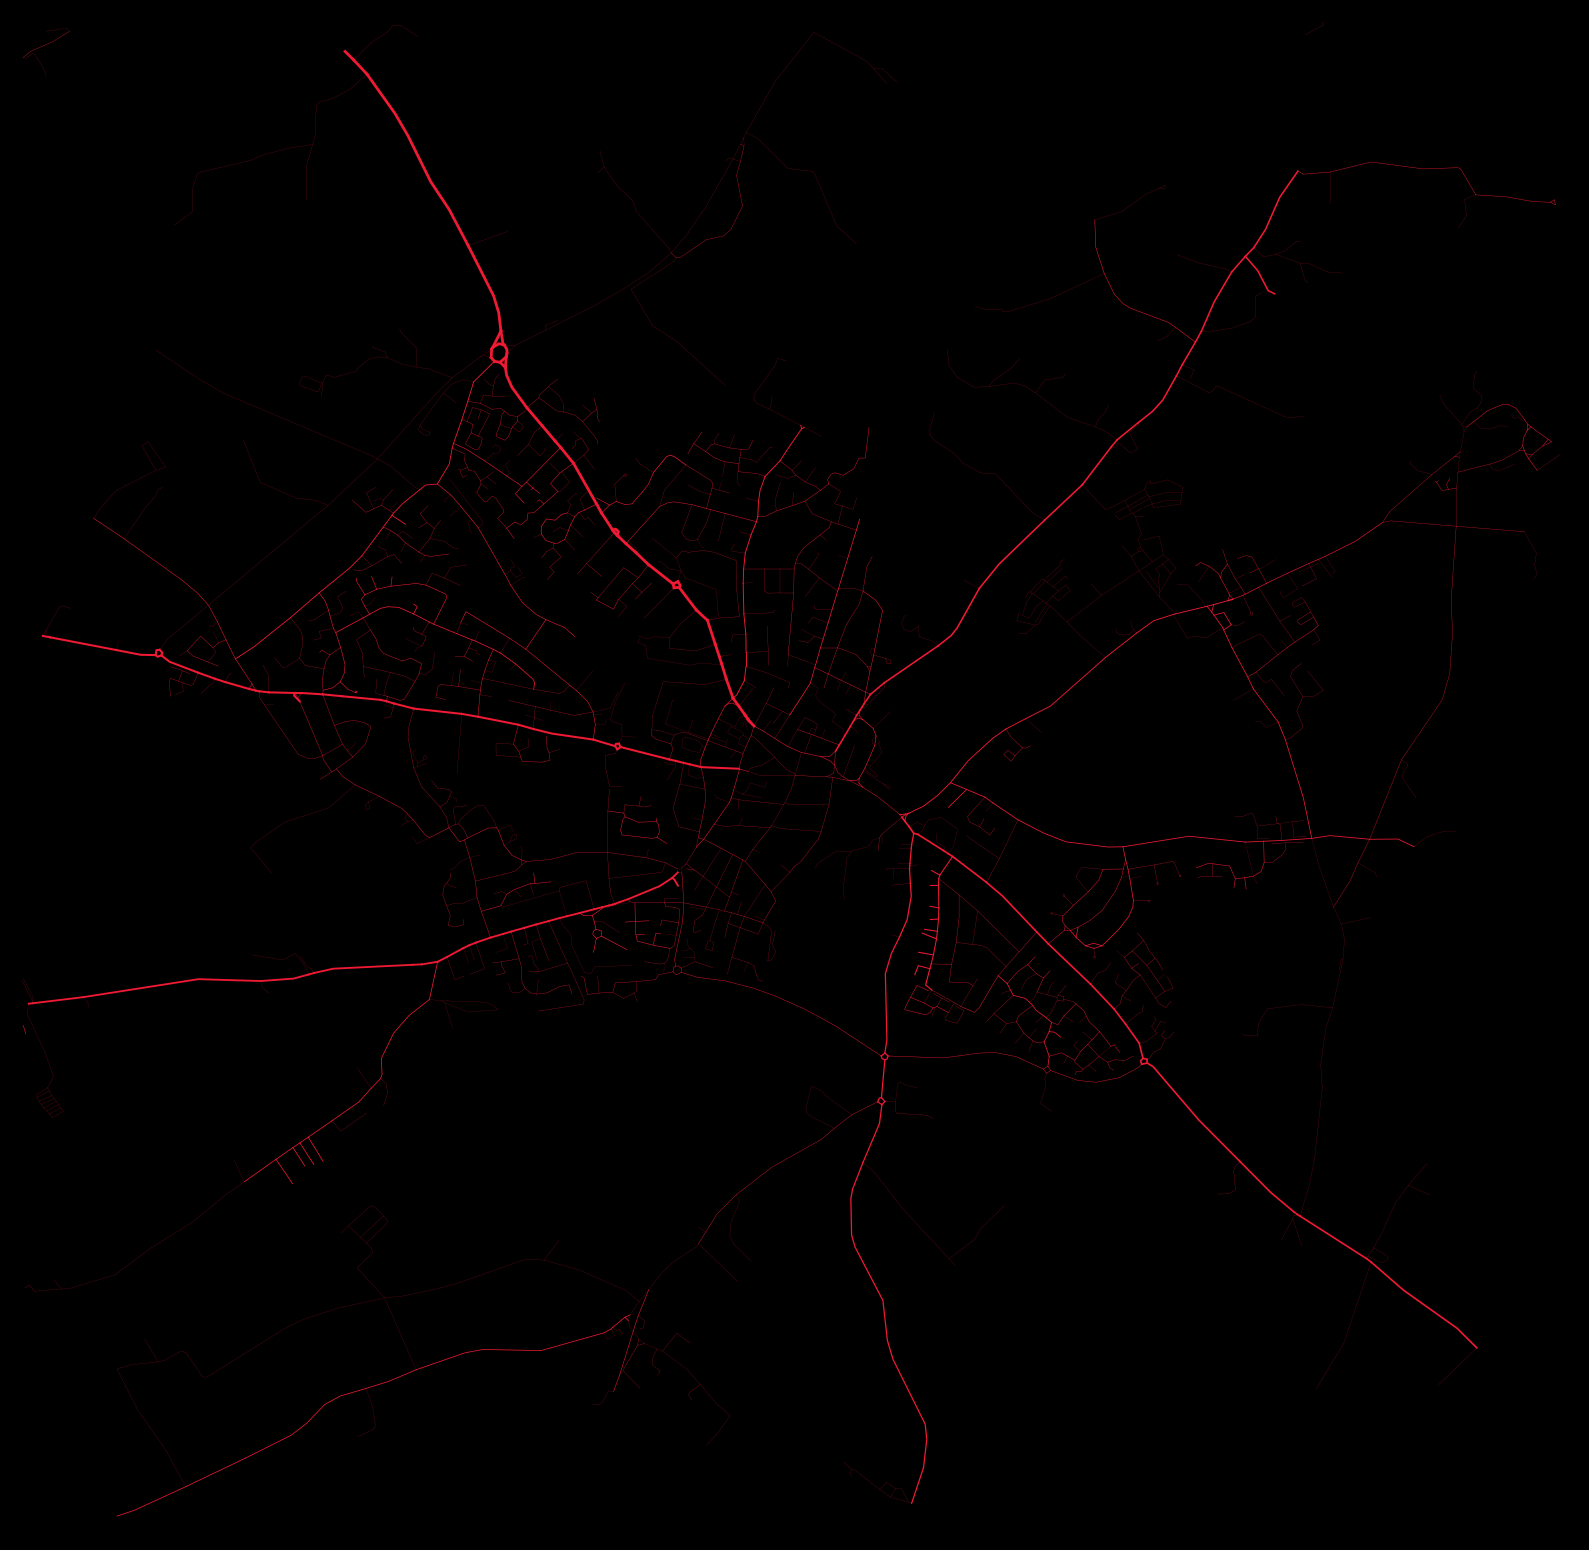

100%|██████████| 2253/2253 [00:01<00:00, 2138.27it/s]


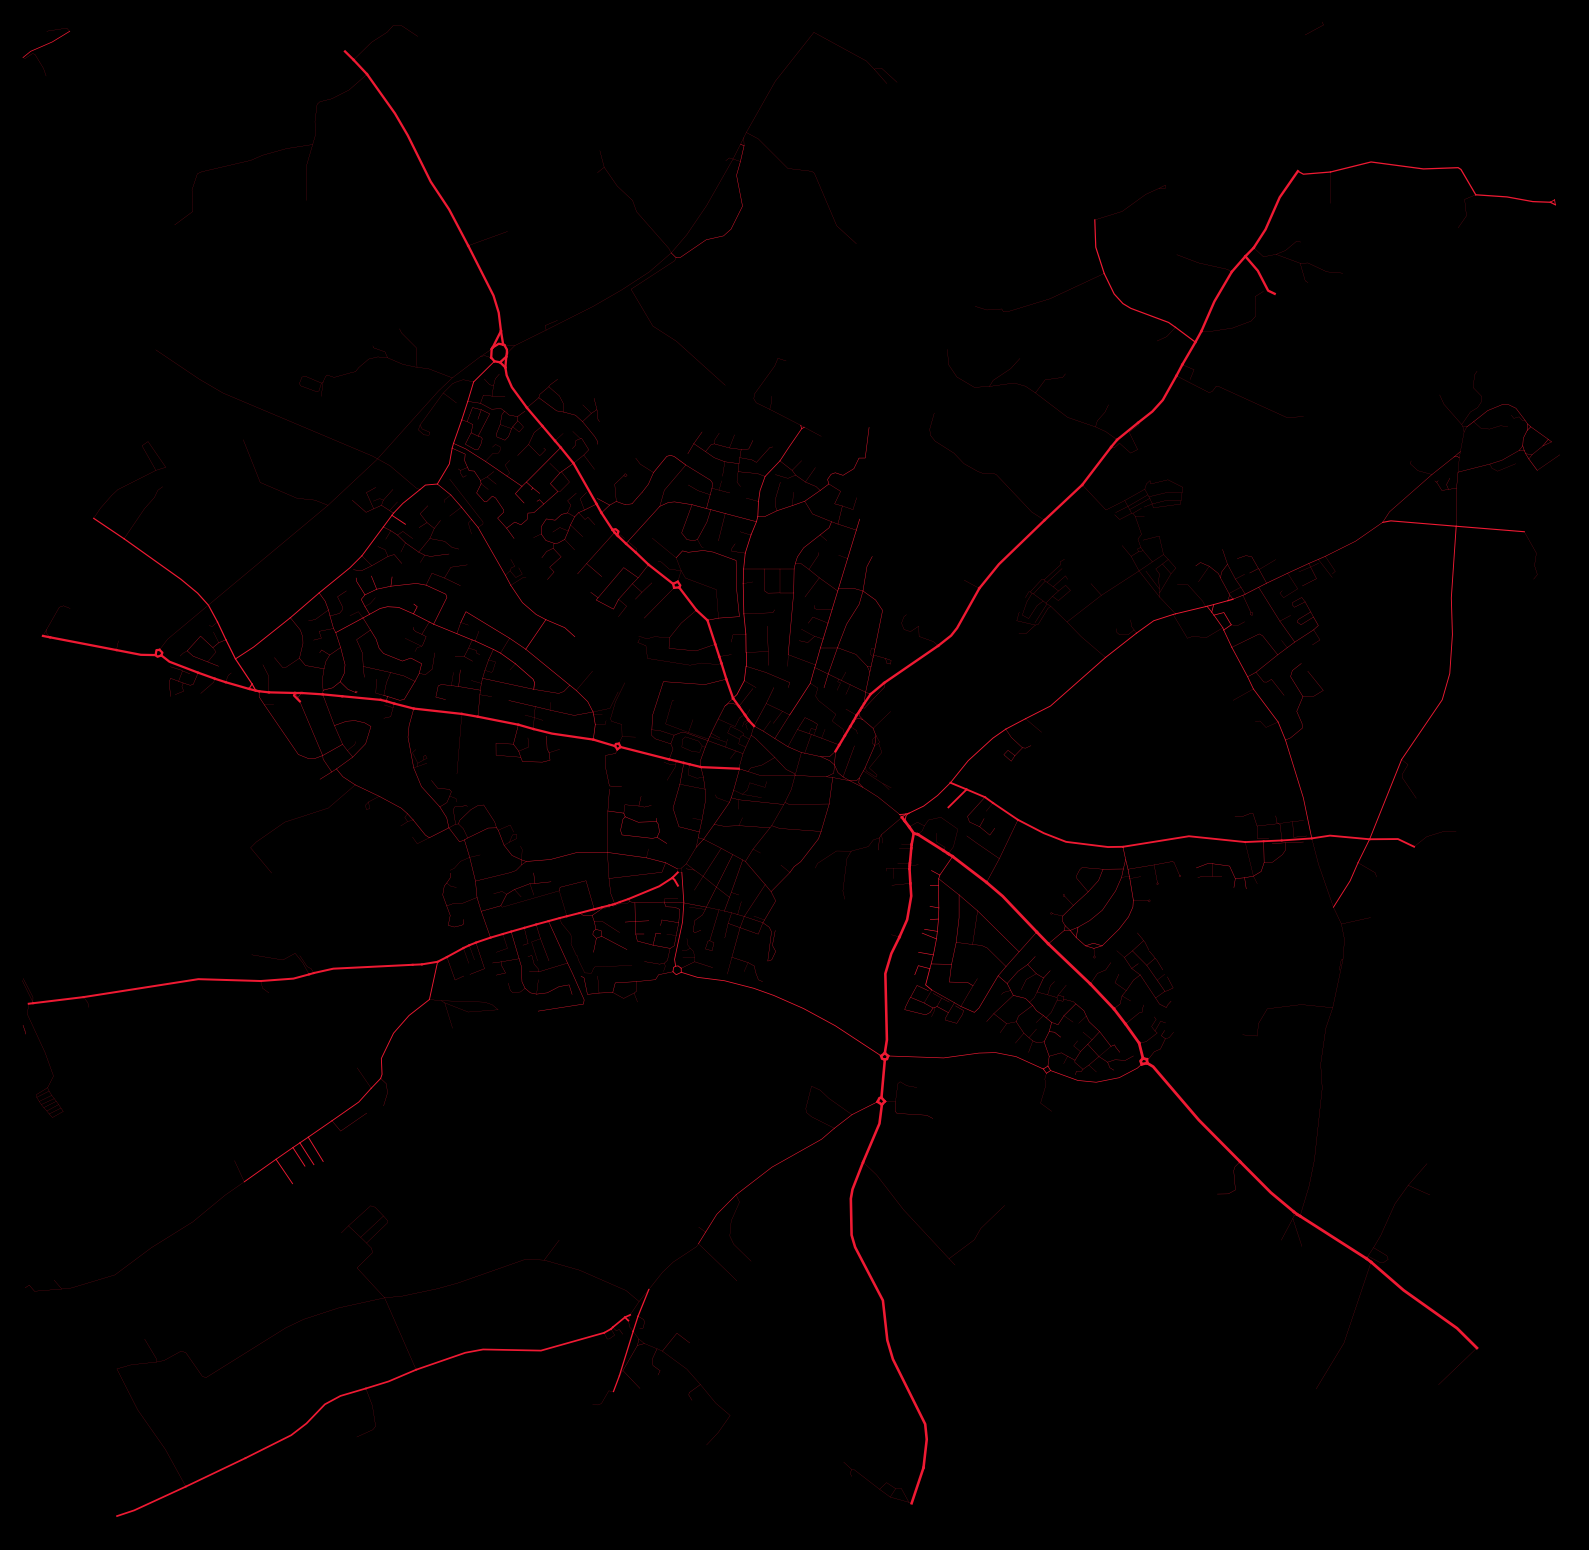

In [4]:
import matplotlib.pyplot as plt

from cityseer.metrics import observe

from demos.general_util import plot_funcs

# methods can be "names", "refs", "highways"
G_cont = observe.route_continuity(G_open, method="names")

# plot
_fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 10))
plot_funcs.plot_nx_edges(ax, G_cont, "names_agg_count", plot_bbox)
plt.show()
_fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 10))
plot_funcs.plot_nx_edges(ax, G_cont, "names_agg_length", plot_bbox)
plt.show()